In [1]:
import numpy as np
from hottbox.core import Tensor
import yfinance as yf
import alphalens
import pandas as pd
from hottbox.pdtools import tensor_to_pd, pd_to_tensor
from hottbox.utils.generation import residual_tensor
from hottbox.algorithms.decomposition import TTSVD, HOSVD, HOOI, CPD
from hottbox.metrics import residual_rel_error, mse, rmse, mape
from hottbox.rank import rank_estimation as re
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import seaborn as sns

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-20", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-20", end="2019-05-21")

[*********************100%***********************]  20 of 20 completed


In [3]:
#log returns

returns = pan["Adj Close"].apply(np.log).diff(1)
returns = returns.stack()
returns.index = returns.index.set_names(['date', 'asset'])
returns = returns.unstack()
# returns.index = returns.index.tz_localize('UTC')
returns = returns.stack()
returns

date        asset
2011-05-20  AAPL    -0.015716
            ADBE    -0.002828
            AMAT    -0.016890
            AMD     -0.002318
            AMZN    -0.000755
                       ...   
2019-05-20  TSLA    -0.027236
            TXN     -0.019479
            V       -0.003786
            VZ       0.015714
            XLNX    -0.036255
Length: 40240, dtype: float64

In [4]:
# Volume

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-21", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-21", end="2019-05-21")

vol = pan["Volume"]
vol = vol.stack()
vol.index = vol.index.set_names(['date', 'asset'])
vol = vol.unstack()
vol = vol.stack()
vol

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     337968400
            ADBE       3246700
            AMAT      17189500
            AMD       16694300
            AMZN       3381000
                       ...    
2019-05-20  TSLA     102631000
            TXN        7519900
            V          4747400
            VZ        20910600
            XLNX      10459300
Length: 40240, dtype: int64

In [5]:
# 5 day open price predictive factor

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-14", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-14", end="2019-05-21")

predictive_factor = pan['Open']
predictive_factor = -predictive_factor.pct_change(5)

predictive_factor = predictive_factor.stack()
predictive_factor.index = predictive_factor.index.set_names(['date', 'asset'])

pricing = pan['Open'].iloc[1:]
pricing.index = pricing.index.tz_localize('UTC')

predictive_factor = predictive_factor.unstack()
predictive_factor = predictive_factor.stack()

predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL     0.017647
            ADBE     0.008112
            AMAT     0.050532
            AMD      0.038117
            AMZN     0.037676
                       ...   
2019-05-20  TSLA     0.125900
            TXN      0.055693
            V       -0.039188
            VZ      -0.042842
            XLNX     0.113267
Length: 40240, dtype: float64

In [6]:
# 10 day open price non-predictive factor 

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

non_predictive_factor = pan["Open"].pct_change(10)
non_predictive_factor = non_predictive_factor.stack()
non_predictive_factor.index = non_predictive_factor.index.set_names(['date', 'asset'])
non_predictive_factor

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.028969
            ADBE     0.064226
            AMAT    -0.062377
            AMD     -0.046667
            AMZN    -0.005776
                       ...   
2019-05-20  TSLA    -0.188865
            TXN     -0.096653
            V        0.032488
            VZ       0.040824
            XLNX    -0.121826
Length: 40240, dtype: float64

In [7]:
# 10-day Momentum

pan = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2011-05-07", end="2019-05-21")
# pan = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2011-05-07", end="2019-05-21")

momentum = pan["Adj Close"].pct_change(10)
momentum = momentum.stack()
momentum.index = momentum.index.set_names(['date', 'asset'])
momentum

[*********************100%***********************]  20 of 20 completed


date        asset
2011-05-20  AAPL    -0.033000
            ADBE     0.057186
            AMAT    -0.074852
            AMD     -0.033632
            AMZN     0.005314
                       ...   
2019-05-20  TSLA    -0.195739
            TXN     -0.096064
            V        0.008882
            VZ       0.036901
            XLNX    -0.146862
Length: 40240, dtype: float64

In [8]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# We are interested in the US stock-market.
market = 'us'

# List of tickers we want. If None then all tickers are used.
tickers = sorted(["GOOG","AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

# %%time
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices,
                 )

# %%time
df_val_signals_daily = hub.val_signals(variant='daily')

Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-income-ttm" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (13 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (13 days old).
- Loading from disk ... Done!
Cache-file 'val_signals-4c3c6a0f.pickle' on disk (0 days old).
- Loading from disk ... Done!


In [9]:
# Price to book value
df_pbv = pd.DataFrame()
for i in tickers:
    df_pbv[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Price to Book Value"]
df_pbv.fillna(0,inplace=True)

df_pbv = df_pbv.stack()
df_pbv.index = df_pbv.index.set_names(['date', 'asset'])
df_pbv = df_pbv.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pbv = df_pbv.stack()
pbv = df_pbv.fillna(0)
df_pbv

date        asset
2011-05-20  AAPL      5.689950
            ADBE      3.387547
            AMAT      0.000000
            AMD       6.237374
            AMZN     13.197028
                       ...    
2019-05-20  TSLA      6.081886
            TXN      11.527985
            V        13.255717
            VZ        4.456760
            XLNX      9.745485
Length: 40240, dtype: float64

In [10]:
# Market Cap
df_mc = pd.DataFrame()
for i in tickers:
    df_mc[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["Market-Cap"]
df_mc.fillna(0,inplace=True)

df_mc = df_mc.stack()
df_mc.index = df_mc.index.set_names(['date', 'asset'])
df_mc = df_mc.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_mc = df_mc.stack()
df_mc

date        asset
2011-05-20  AAPL     3.110468e+11
            ADBE     1.837882e+10
            AMAT     0.000000e+00
            AMD      6.318460e+09
            AMZN     9.058440e+10
                         ...     
2019-05-20  TSLA     3.501731e+10
            TXN      1.036827e+11
            V        4.519537e+11
            VZ       2.438293e+11
            XLNX     2.570074e+10
Length: 40240, dtype: float64

In [11]:
# P/E
df_pe = pd.DataFrame()
for i in tickers:
    df_pe[i] = df_val_signals_daily.loc[i]['2011-05-20':'2019-05-20']["P/E"]
df_pe.fillna(0,inplace=True)

df_pe = df_pe.stack()
df_pe.index = df_pe.index.set_names(['date', 'asset'])
df_pe = df_pe.unstack()
# returns.index = returns.index.tz_localize('UTC')
df_pe = df_pe.stack()
df_pe

date        asset
2011-05-20  AAPL     18.693842
            ADBE     20.834900
            AMAT      0.000000
            AMD      13.414989
            AMZN     78.632292
                       ...    
2019-05-20  TSLA    -35.875045
            TXN      18.581129
            V        42.018751
            VZ       15.702558
            XLNX     31.552038
Length: 40240, dtype: float64

In [12]:
from datetime import datetime

data = {'Date': list(returns.index.get_level_values('date')),
        'Asset': list(returns.index.get_level_values('asset')),
        'Returns': returns,
        'Volume': vol,
        'Predictive_Factor': predictive_factor,
        'Non_Predictive_Factor': non_predictive_factor,
        'Momentum': momentum,
        'Price_to_Book_Value': df_pbv.fillna(0),
        'Market_Cap': df_mc.fillna(0),
        'P/E': df_pe.fillna(0)
       }

#df_original = pd.DataFrame.from_dict(data)
#df_original.set_index(["Date","Asset","Returns","Volume","Predictive Factor","Non-Predictive Factor","Momentum","Price to book Value","Market Cap"], inplace=True)
df_original = pd.DataFrame({'Date': data['Date'], 'Asset': data['Asset'],'Returns': data['Returns'].values, 'Volume': data['Volume'].values, 'Predictive Factor': data['Predictive_Factor'].values, 'Non-Predictive Factor': data['Non_Predictive_Factor'].values, 'Momentum': data['Momentum'].values, 'Price to book Value': data['Price_to_Book_Value'].values,'Market Cap': data['Market_Cap'].values,'P/E': data['P/E'].values })
df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']] = StandardScaler().fit_transform(df_original[['Returns', 'Volume','Predictive Factor','Non-Predictive Factor','Momentum','Price to book Value','Market Cap','P/E']])
df_original

,Date,Asset,Returns,Volume,Predictive Factor,Non-Predictive Factor,Momentum,Price to book Value,Market Cap,P/E
0,2011-05-20,AAPL,-0.810748,4.168957,0.481235,-0.585197,-0.658513,-0.139992,0.700790,-0.057583
1,2011-05-20,ADBE,-0.173145,-0.364517,0.269450,0.889325,0.762768,-0.335640,-0.730837,-0.048815
2,2011-05-20,AMAT,-0.868855,-0.175676,1.211605,-1.113785,-1.318079,-0.623497,-0.820739,-0.134140
3,2011-05-20,AMD,-0.147891,-0.182383,0.935859,-0.865218,-0.668475,-0.093475,-0.789831,-0.079201
4,2011-05-20,AMZN,-0.070578,-0.362698,0.926078,-0.218245,-0.054706,0.497923,-0.377633,0.187881
...,...,...,...,...,...,...,...,...,...,...
40235,2019-05-20,TSLA,-1.380690,0.981545,2.885535,-3.115083,-3.223191,-0.106688,-0.649447,-0.281058
40236,2019-05-20,TXN,-0.996915,-0.306641,1.326232,-1.656099,-1.652367,0.356096,-0.313561,-0.058045
40237,2019-05-20,V,-0.220526,-0.344192,-0.781094,0.387177,0.001531,0.502910,1.390056,0.037939
40238,2019-05-20,VZ,0.744173,-0.125277,-0.862245,0.519055,0.443085,-0.244783,0.371986,-0.069833


In [13]:
tensor = []
tensor_date = []
for i in range(len(df_original.loc[:,'Asset'])):
    if len(tensor_date)==len(tickers):
        tensor.append(tensor_date) 
        tensor_date = []
        
    tensor_date.append([df_original.loc[:,'Returns'].values[i], df_original.loc[:,'Volume'].values[i], df_original.loc[:,'Predictive Factor'].values[i], df_original.loc[:,'Non-Predictive Factor'].values[i], df_original.loc[:,'Momentum'].values[i], df_original.loc[:,'Price to book Value'].values[i], df_original.loc[:,'Market Cap'].values[i], df_original.loc[:,'P/E'].values[i]])  
    
    

In [14]:
np.array(tensor)

array([[[-8.10748490e-01,  4.16895682e+00,  4.81234908e-01, ...,
         -1.39992429e-01,  7.00790198e-01, -5.75831094e-02],
        [-1.73145036e-01, -3.64517363e-01,  2.69449957e-01, ...,
         -3.35639705e-01, -7.30836528e-01, -4.88148866e-02],
        [-8.68855095e-01, -1.75675935e-01,  1.21160491e+00, ...,
         -6.23497255e-01, -8.20739108e-01, -1.34139522e-01],
        ...,
        [-9.16963941e-01, -1.75317019e-01,  2.72517890e-01, ...,
         -2.20136248e-01, -2.27615748e-01,  2.67163327e-02],
        [-2.59119417e-01, -2.64450151e-01,  2.43231469e-01, ...,
         -5.20596638e-01, -3.05913745e-01,  3.49507304e-02],
        [-4.32721935e-01, -3.62254159e-01,  2.42414348e-01, ...,
         -2.46475821e-01, -7.73564416e-01, -7.14850104e-02]],

       [[-1.54432783e-01,  4.78699168e+00,  6.93646109e-01, ...,
         -1.41204220e-01,  6.96976842e-01, -5.77749801e-02],
        [-1.28184801e+00, -3.59660481e-01,  3.48496285e-01, ...,
         -3.42813725e-01, -7.33077090e

In [15]:
from corcondia import corcondia_3d
print(corcondia_3d(np.array(tensor), k=9))

-285798.69445791637


In [16]:
tensor_data = Tensor(np.array(tensor))
print(tensor_data)

This tensor is of order 3 and consists of 321760 elements.
Sizes and names of its modes are (2011, 20, 8) and ['mode-0', 'mode-1', 'mode-2'] respectively.


# Training

In [17]:
alg = CPD()
alg

CPD(epsilon=0.01, init='svd', max_iter=50, random_state=None, tol=0.0001,
    verbose=False)

In [18]:
kruskal_rank = (100,)

tensor_cpd = alg.decompose(tensor_data, rank=kruskal_rank)
print("\tOutput of the {} algorithm:".format(alg.name))
print(tensor_cpd)

print('\n\tFactor matrices')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
    
print('\n\tCore tensor')
print(tensor_cpd.core)
tensor_cpd.core.data

	Output of the CPD algorithm:
Kruskal representation of a tensor with rank=(100,).
Factor matrices represent properties: ['mode-0', 'mode-1', 'mode-2']
With corresponding latent components described by (2011, 20, 8) features respectively.

	Factor matrices
Mode-0 factor matrix is of shape (2011, 100)
Mode-1 factor matrix is of shape (20, 100)
Mode-2 factor matrix is of shape (8, 100)

	Core tensor
This tensor is of order 3 and consists of 1000000 elements.
Sizes and names of its modes are (100, 100, 100) and ['mode-0', 'mode-1', 'mode-2'] respectively.


array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [19]:
print('\n\Factor tensor')
for mode, fmat in enumerate(tensor_cpd.fmat):
    print('Mode-{} factor matrix is of shape {}'.format(mode, fmat.shape))
tensor_cpd.fmat


\Factor tensor
Mode-0 factor matrix is of shape (2011, 100)
Mode-1 factor matrix is of shape (20, 100)
Mode-2 factor matrix is of shape (8, 100)


[array([[ 0.00224217,  0.44222378,  0.13101043, ..., -0.04690526,
          0.03350213, -0.05846686],
        [ 0.00070146,  0.43630543,  0.13520283, ..., -0.16281083,
         -0.04114114,  0.03586488],
        [-0.08175803,  0.29459816,  0.07111834, ..., -0.17668851,
         -0.1200921 ,  0.07864275],
        ...,
        [ 0.15339738, -0.54328546,  0.17004522, ...,  0.06273626,
          0.18193961, -0.07862351],
        [ 0.0016701 , -0.29679276,  0.05653888, ...,  0.1475515 ,
          0.25537976, -0.53418113],
        [-0.20914837, -0.36270591,  0.21825418, ...,  0.64185771,
         -0.47528942, -0.23203352]]),
 array([[-2.66987693,  0.78889008, -1.69333934, ...,  1.75511029,
          0.03129353,  0.10302201],
        [-0.39499702, -0.57516848, -0.36808577, ...,  0.28412716,
          0.05058408, -0.20138465],
        [-0.40679079, -0.57844985, -0.23849176, ...,  0.38747684,
         -0.64529185, -0.047368  ],
        ...,
        [-0.45176848, -0.6032908 ,  0.20938711, ...,  

In [20]:
index = sorted(["GOOGL", "AAPL", "AMD", "TSLA", "NFLX", "TXN", "AMAT", "AMZN", "INTC", "NVDA", "ADBE", "CSCO", "V", "IBM", "QCOM", "MSFT", "XLNX", "HPQ", "VZ", "T"])
# index = sorted(["BAC", "JPM", "GS", "C", "MS", "HSBC", "BNPQY", "BCS", "LYG", "UBS", "CS", "WFC", "RY", "SCHW", "TD", "HDB", "USB", "PNC", "TFC", "BNS"])


df = pd.DataFrame(tensor_cpd.fmat[1], columns = [i for i in range(tensor_cpd.fmat[1].shape[1])], index = index)
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
AAPL,-2.669877,0.788890,-1.693339,1.147917,3.195111,-0.148874,1.201268,0.678537,0.421018,1.818273,...,0.560227,1.826438,1.139838,0.331714,1.002204,1.309151,0.120603,1.755110,0.031294,0.103022
ADBE,-0.394997,-0.575168,-0.368086,-0.485761,0.117174,-0.585453,1.635742,0.203013,-0.278729,-0.457023,...,0.110619,0.079964,-0.390909,0.038247,0.230696,-2.032904,-0.633773,0.284127,0.050584,-0.201385
AMAT,-0.406791,-0.578450,-0.238492,-0.654598,-0.060242,-0.351719,1.499414,0.009630,-0.192457,-0.502326,...,0.153917,0.588088,-0.916934,0.389252,0.704810,-0.850770,-0.686151,0.387477,-0.645292,-0.047368
AMD,1.082903,0.320977,1.922358,-0.198513,1.735598,-1.663486,0.059075,-0.763237,-1.401917,-0.211771,...,-0.082724,0.617844,0.163067,1.010239,0.906149,0.507735,2.446225,-3.215718,1.383618,0.618284
AMZN,-1.751450,-0.761752,-1.320456,0.323473,1.338325,0.568991,-1.894300,-1.576511,-1.080416,-0.270976,...,-1.788858,0.650915,-3.089973,0.142447,-3.179875,-0.651969,-1.047826,0.259430,2.216864,-1.158136
CSCO,0.410652,-1.252241,-0.309222,0.703501,-0.494708,-1.060468,-1.905170,1.159264,0.902440,-0.582493,...,-1.185290,-0.511652,0.835814,0.633830,1.650702,-0.087946,0.540659,0.302560,-0.350496,1.047550
GOOGL,-1.208262,-1.326720,1.140761,0.014359,0.661287,-0.306882,0.895408,-0.848207,-0.861952,0.645877,...,-1.276536,0.330862,0.137856,0.455664,-0.041588,0.037749,-1.373468,0.836025,0.047880,-0.889352
HPQ,1.846230,1.830967,1.054570,-0.165791,1.095927,0.831176,-1.771153,2.045127,2.116275,0.884353,...,-2.327670,1.517122,0.556538,1.013129,-0.069017,-0.450330,0.183341,0.789552,-0.465634,-1.293836
IBM,0.364946,0.089586,0.076005,-0.388123,0.180059,0.204621,-0.591677,0.258149,0.339201,0.213562,...,-0.277528,-0.294976,0.254565,0.296242,-0.222685,0.106494,0.681506,-0.486957,-0.068556,-0.073739
INTC,-0.290747,-0.655328,0.445783,-0.209438,0.399246,-0.356896,-0.141932,0.651574,0.327707,0.405190,...,-0.110930,0.216716,-0.137428,0.071511,0.249420,-0.272245,-0.434438,0.165045,-0.382510,-0.368554


## PCA

In [21]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(df.transpose())
pca.components_[0]

array([ 0.367045  ,  0.22971802,  0.26602278,  0.25504877,  0.30252899,
        0.11946332,  0.23230987, -0.0123904 , -0.00530115,  0.17942773,
        0.17697766,  0.13793925,  0.42824843,  0.3117287 , -0.01525952,
        0.22058613,  0.21204432,  0.13701316, -0.00472138,  0.20243989])

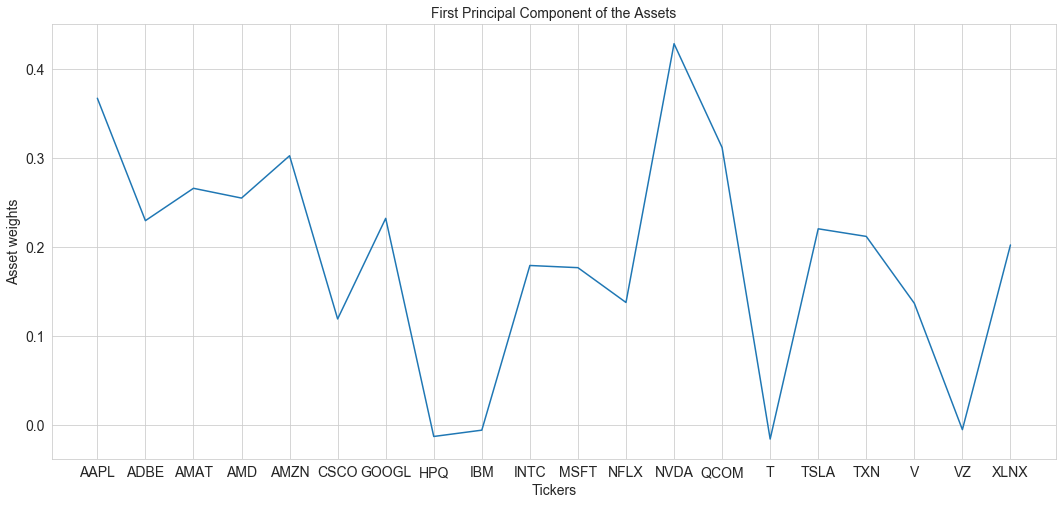

In [22]:
fig, axes = plt.subplots(1)
pc1 = pd.Series(index=index, data=pca.components_[0])
pc1.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='First Principal Component of the assets',fontsize=14)
axes.set_ylabel('Asset weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title('First Principal Component of the Assets',fontsize=14)
fig.set_size_inches(18, 8) 

In [23]:
pc1.sort_values()

T       -0.015260
HPQ     -0.012390
IBM     -0.005301
VZ      -0.004721
CSCO     0.119463
V        0.137013
NFLX     0.137939
MSFT     0.176978
INTC     0.179428
XLNX     0.202440
TXN      0.212044
TSLA     0.220586
ADBE     0.229718
GOOGL    0.232310
AMD      0.255049
AMAT     0.266023
AMZN     0.302529
QCOM     0.311729
AAPL     0.367045
NVDA     0.428248
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

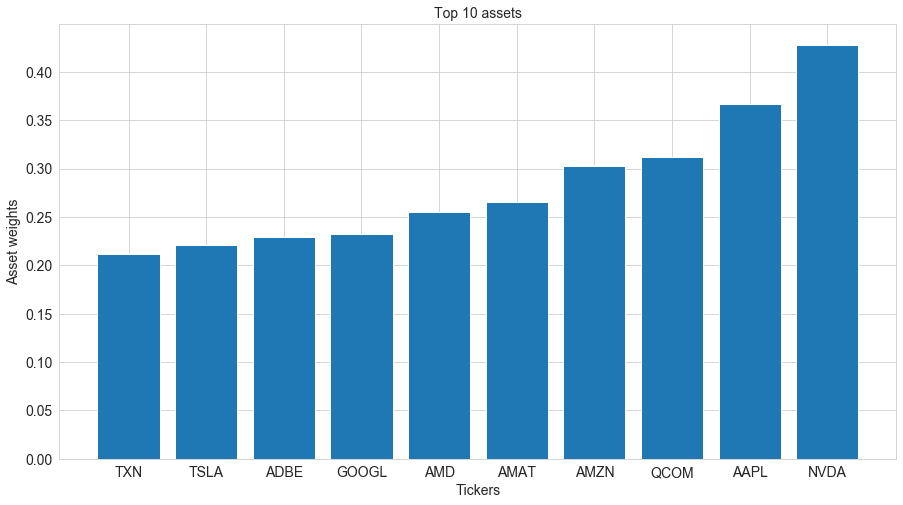

In [24]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(pc1.sort_values().index[-10:],pc1.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

## ICA

In [25]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=10,random_state=0).fit(df.transpose().fillna(0))


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


[*********************100%***********************]  20 of 20 completed


Text(0.5, 1.0, 'Independent Components')

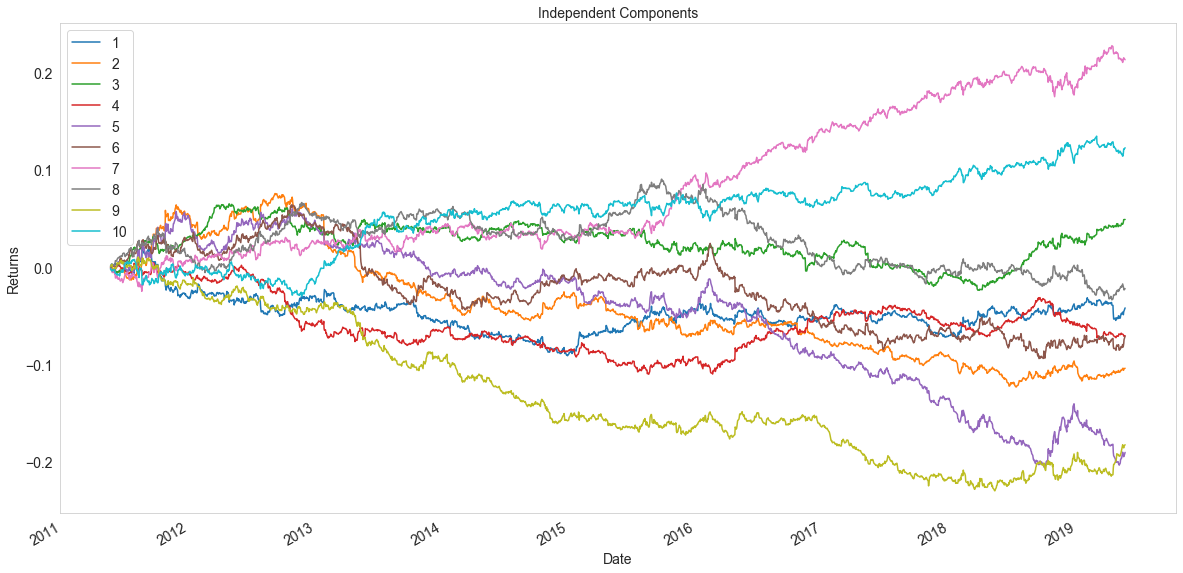

In [26]:
fig, ax = plt.subplots(1, figsize=(20, 10)) 
pan = yf.download(tickers, start="2011-05-20", end="2019-05-21")
ret = pan["Adj Close"].apply(np.log).diff(1)
for i in range(10):
    ret.dot(ica.components_[i]).cumsum().plot(ax=ax,fontsize=14)
ax.legend([str(i) for i in range(1,11,1)],fontsize=14)
ax.grid()
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title("Independent Components",fontsize=14)

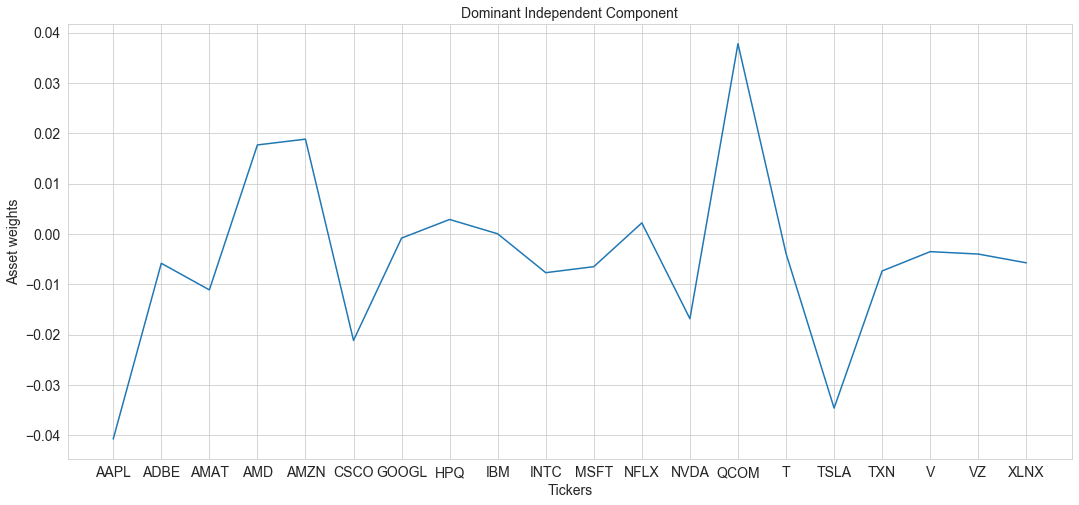

In [27]:
fig, axes = plt.subplots(1)
#tech
ica_tech = pd.Series(index=df.transpose().columns, data=ica.components_[6])
ica_tech.plot(ax=axes, xticks=np.arange(0, 20, 1.0),  title='Dominant Independent Component',fontsize=14)
axes.set_ylabel('Asset weights', fontsize=14)
axes.set_xlabel('Tickers', fontsize=14)
axes.set_title('Dominant Independent Component',fontsize=14)
fig.set_size_inches(18, 8) 

In [28]:
ica_tech.sort_values()

AAPL    -0.040725
TSLA    -0.034583
CSCO    -0.021143
NVDA    -0.016826
AMAT    -0.011101
INTC    -0.007687
TXN     -0.007348
MSFT    -0.006492
ADBE    -0.005824
XLNX    -0.005733
VZ      -0.003989
T       -0.003868
V       -0.003509
GOOGL   -0.000819
IBM      0.000033
NFLX     0.002202
HPQ      0.002881
AMD      0.017683
AMZN     0.018830
QCOM     0.037791
dtype: float64

Text(0.5, 1.0, 'Top 10 assets')

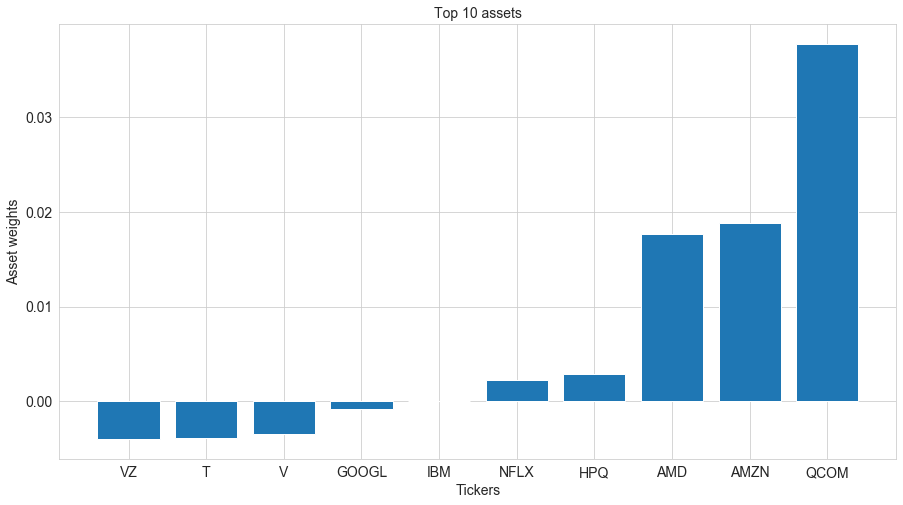

In [29]:
from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(15, 8))
plt.bar(ica_tech.sort_values().index[-10:],ica_tech.sort_values().values[-10:])
plt.ylabel('Asset weights', fontsize=14)
plt.xlabel('Tickers', fontsize=14)
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.title("Top 10 assets",fontsize=14)

# Testing

In [30]:
test = yf.download("GOOGL AAPL AMD TSLA NFLX TXN AMAT AMZN INTC NVDA ADBE CSCO V IBM QCOM MSFT XLNX HPQ VZ T", start="2019-05-19", end="2021-05-20")
# test = yf.download("BAC JPM GS C MS HSBC BNPQY BCS LYG UBS CS WFC RY SCHW TD HDB USB PNC TFC BNS", start="2019-05-19", end="2021-05-20")

returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  20 of 20 completed


date        asset
2019-05-21  AAPL     0.018989
            ADBE     0.009467
            AMAT     0.022545
            AMD      0.024802
            AMZN    -0.000780
                       ...   
2021-05-19  TSLA    -0.025253
            TXN      0.015808
            V       -0.004354
            VZ      -0.004557
            XLNX     0.024732
Length: 10080, dtype: float64

## PCA

In [31]:
mean_returns = []

for i in range(0,len(returns_test),20):
    mean_returns.append(returns_test[i:i+20].values.dot(abs(pca.components_[0])/sum(abs(pca.components_[0]))).mean())
mean_returns


[0.015559745542294692,
 -0.01763715243057089,
 -0.017395115868297114,
 -0.006624904703666178,
 0.00144155850988776,
 -0.006081075039488568,
 0.0038055164168423394,
 -0.018362586327689764,
 -0.017258622121512843,
 0.04075855120335828,
 0.0031051293246720517,
 0.01711107943652198,
 0.015389705976079757,
 0.019098990637227274,
 0.003859691234392308,
 -0.017062274638320694,
 0.003813567584220606,
 -0.013315320446193503,
 0.0023358462587268584,
 0.027658160588874128,
 0.004997563094696021,
 0.008072886417260599,
 -0.005165998070264775,
 0.0018746477125191523,
 -0.01749247490386263,
 0.02121271866764229,
 0.01097056251941132,
 -0.0002109843151462704,
 0.016163313443046633,
 -0.004238906917671926,
 0.006495697066690334,
 -0.0031600045930868805,
 -0.006851626537549922,
 0.007211179726858038,
 0.01005371692847795,
 0.003078022556417456,
 0.010296264165765623,
 0.006702524428069853,
 -0.005610072993467987,
 -0.00023330718352014015,
 -0.0003491547197623956,
 -0.006350448904027019,
 0.013509339192

In [32]:
df_ret = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

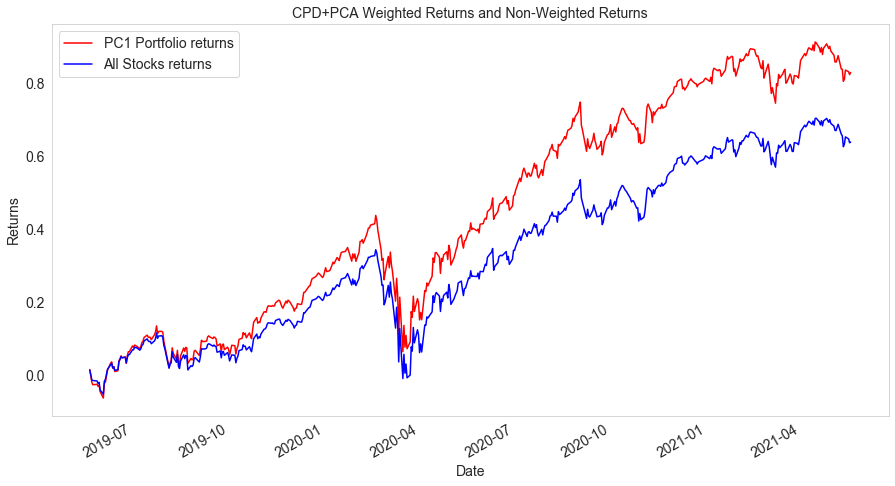

In [33]:
mean_pca = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_ret.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,42.603%
Cumulative returns,103.356%
Annual volatility,34.493%
Sharpe ratio,1.20
Calmar ratio,1.26
Stability,0.92
Max drawdown,-33.761%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.76,2020-02-19,2020-03-16,2020-07-02,97
1,14.28,2021-02-12,2021-03-08,2021-04-13,43
2,14.05,2020-09-02,2020-09-23,2020-11-27,63
3,10.90,2019-07-24,2019-08-05,2019-10-25,68
4,10.45,2021-04-15,2021-05-12,NaT,NaN


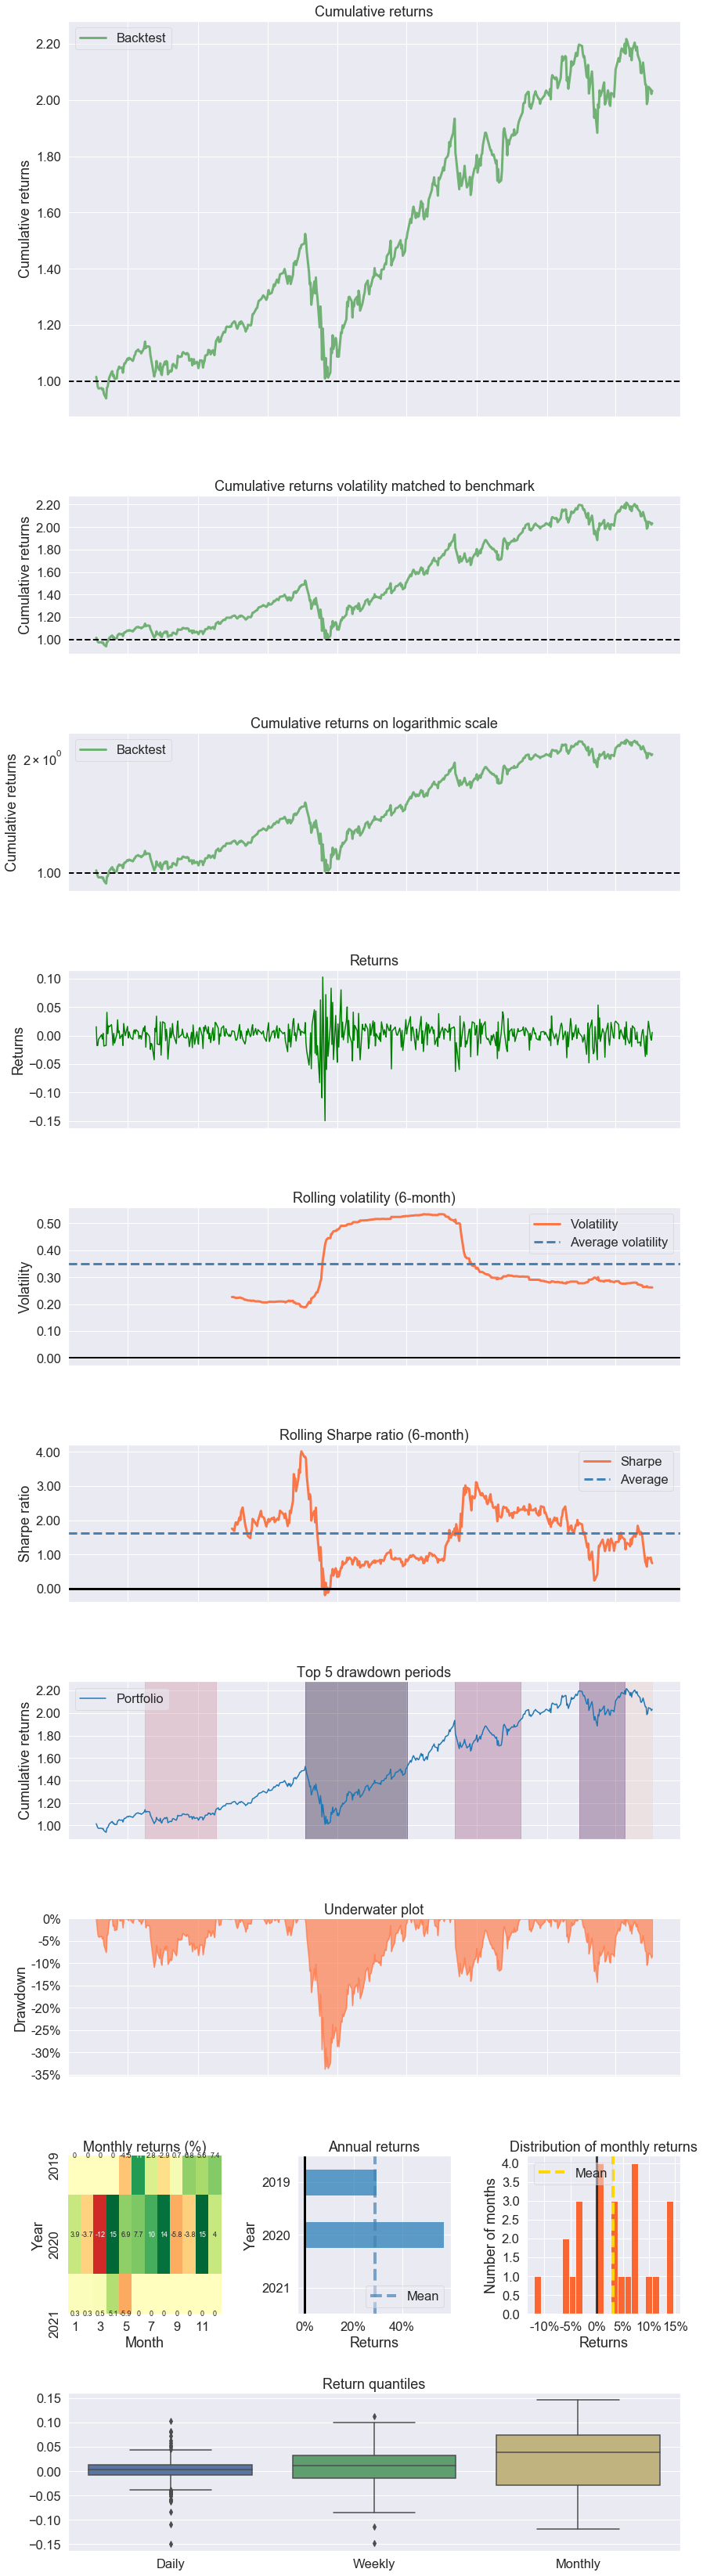

In [34]:
import pyfolio as pf
pf.create_returns_tear_sheet(df_ret)

## ICA

In [35]:
mean_returns = []

for i in range(0,len(returns_test),20):
    mean_returns.append(returns_test[i:i+20].values.dot(ica.components_[6]).mean())
mean_returns

[-0.0011820672904578385,
 -0.00045589611121257714,
 0.00016698936498665845,
 0.0004772791882949029,
 0.0025760551051588606,
 -0.00020064941842902782,
 0.00015890956119854574,
 0.002787014484144409,
 0.0013630998672683411,
 -0.004764691827698403,
 -0.002260646013747952,
 -0.0014211240131040167,
 -0.0005438898121606893,
 -0.0012440404571237287,
 -0.0018539424641298384,
 0.002242060280034566,
 -0.0014152265810237344,
 0.0003950835919810811,
 -0.002072810765916485,
 -0.000986253350651017,
 -0.0005197107674037295,
 -0.0002876187989307968,
 -0.00022534184386961099,
 -5.3402864832254883e-05,
 0.0017638374445158008,
 -0.0007311113893260772,
 -0.00043064517427423286,
 0.0003849159435520881,
 -0.0006790548970323963,
 0.0003085863280238435,
 -0.0026316427199712922,
 0.0010094491795091813,
 0.0023451948112300823,
 0.00044377359438527717,
 -0.003329621695177398,
 -0.0014793033811775658,
 -0.0016053352763617515,
 -0.000760262529647623,
 0.0006948400833517259,
 -0.00046332534493752223,
 -0.0026336470

In [36]:
df_w = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

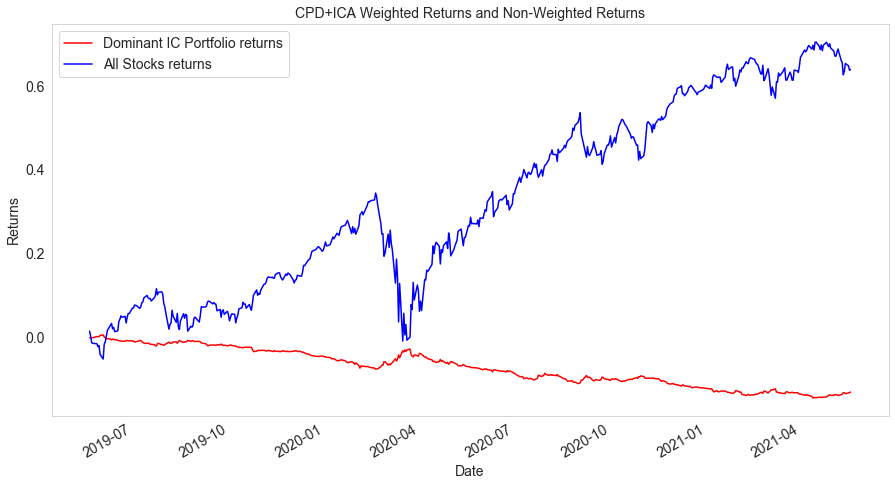

In [37]:
mean_ica = test["Adj Close"].apply(np.log).diff(1).mean(1)
fig,ax = plt.subplots(1,figsize=(15, 8))
df_w.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Dominant IC Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+ICA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

CPD+ICA


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,-6.412%
Cumulative returns,-12.413%
Annual volatility,4.061%
Sharpe ratio,-1.61
Calmar ratio,-0.45
Stability,0.97
Max drawdown,-14.149%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.15,2019-06-03,2021-04-13,NaT,NaN
1,0.05,2019-05-21,2019-05-22,2019-05-24,4
2,0.02,2019-05-28,2019-05-29,2019-05-31,4
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


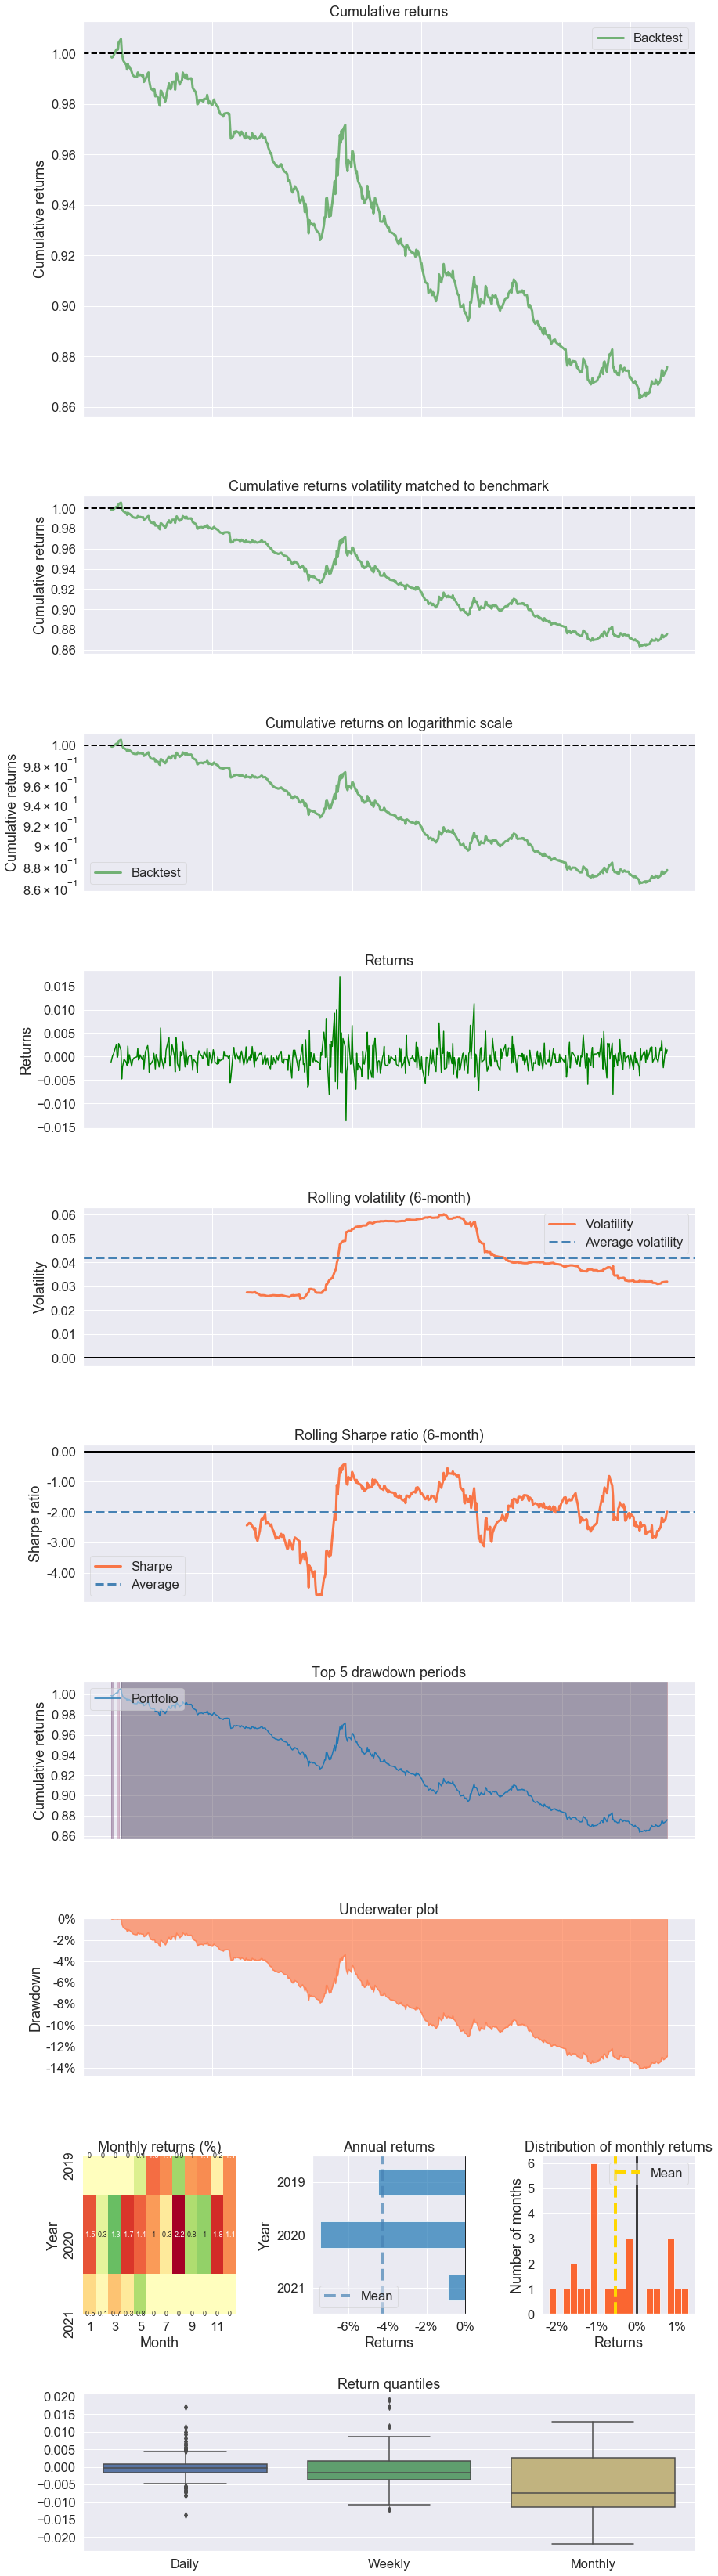

In [38]:
import pyfolio as pf
print("CPD+ICA")
pf.create_returns_tear_sheet(df_w)

## Top 10

## PCA

In [39]:
dominant_assets = pc1.sort_values().index[-10:]
dominant_assets = " ".join(dominant_assets)
dominant_assets

'TXN TSLA ADBE GOOGL AMD AMAT AMZN QCOM AAPL NVDA'

In [40]:
test = yf.download(dominant_assets, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AAPL     0.018989
            ADBE     0.009467
            AMAT     0.022545
            AMD      0.024802
            AMZN    -0.000780
                       ...   
2021-05-19  GOOGL    0.003983
            NVDA     0.003561
            QCOM     0.013484
            TSLA    -0.025253
            TXN      0.015808
Length: 5040, dtype: float64

In [41]:
mean_returns = []
for i in range(0,len(returns_test),10):
    mean_returns.append(returns_test[i:i+10].mean())
mean_returns

[0.013982717502982389,
 -0.021438750082329427,
 -0.01729429851885298,
 -0.008941613852695518,
 0.004479266927596104,
 -0.007359414359312444,
 0.0025013340766931514,
 -0.01675799937495226,
 -0.01978438444334798,
 0.04288982763830469,
 0.002344351764193009,
 0.02076911160494288,
 0.013715363777012435,
 0.022800076127483894,
 0.0032661562320642546,
 -0.0180399032069547,
 0.004404015543022943,
 -0.013568065488070147,
 0.0018409523437150632,
 0.02630963905291539,
 0.006712870420641037,
 0.005860431607777628,
 -0.005087487157072745,
 0.0008711392439430199,
 -0.016783331073322482,
 0.020765300295577216,
 0.012693560170063112,
 -0.00036199819430664525,
 0.018213434516798088,
 -0.004828037505542948,
 0.007507116360276988,
 -0.0026148894818951883,
 -0.0067176690165061895,
 0.00869505194997,
 0.011767525023257619,
 0.0008644716431608135,
 0.01153255207250492,
 0.009819670921059443,
 -0.005016028994129007,
 0.0002592434013990896,
 0.002099347961690068,
 -0.006328199955842528,
 0.014280303285555584

In [42]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

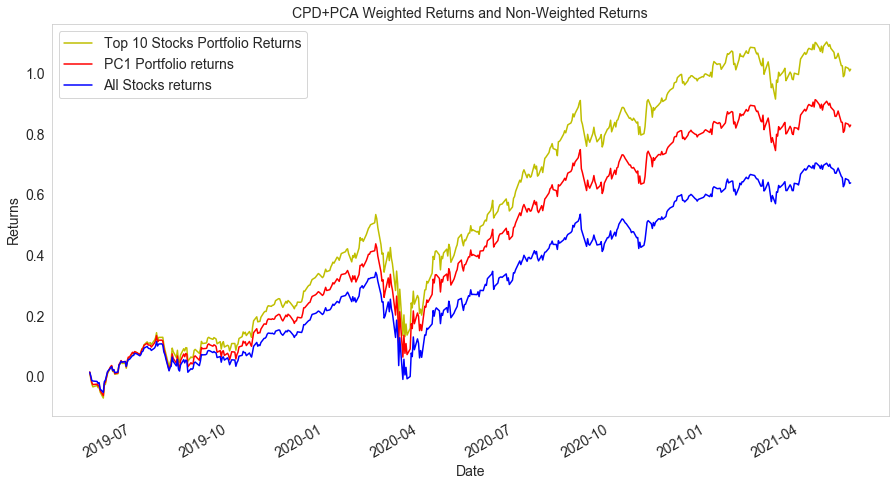

In [43]:
fig,ax = plt.subplots(1,figsize=(15, 8))
df.cumsum().plot(ax=ax, style='y-')
df_ret.cumsum().plot(ax=ax, style='r-')
mean_pca.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

CPD+PCA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,55.305%
Cumulative returns,141.195%
Annual volatility,36.347%
Sharpe ratio,1.40
Calmar ratio,1.53
Stability,0.93
Max drawdown,-36.084%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.08,2020-02-19,2020-03-18,2020-07-02,97
1,16.20,2021-02-12,2021-03-08,2021-04-15,45
2,14.93,2020-09-02,2020-09-23,2020-11-24,60
3,11.00,2021-04-26,2021-05-12,NaT,NaN
4,10.88,2019-07-24,2019-08-05,2019-10-24,67


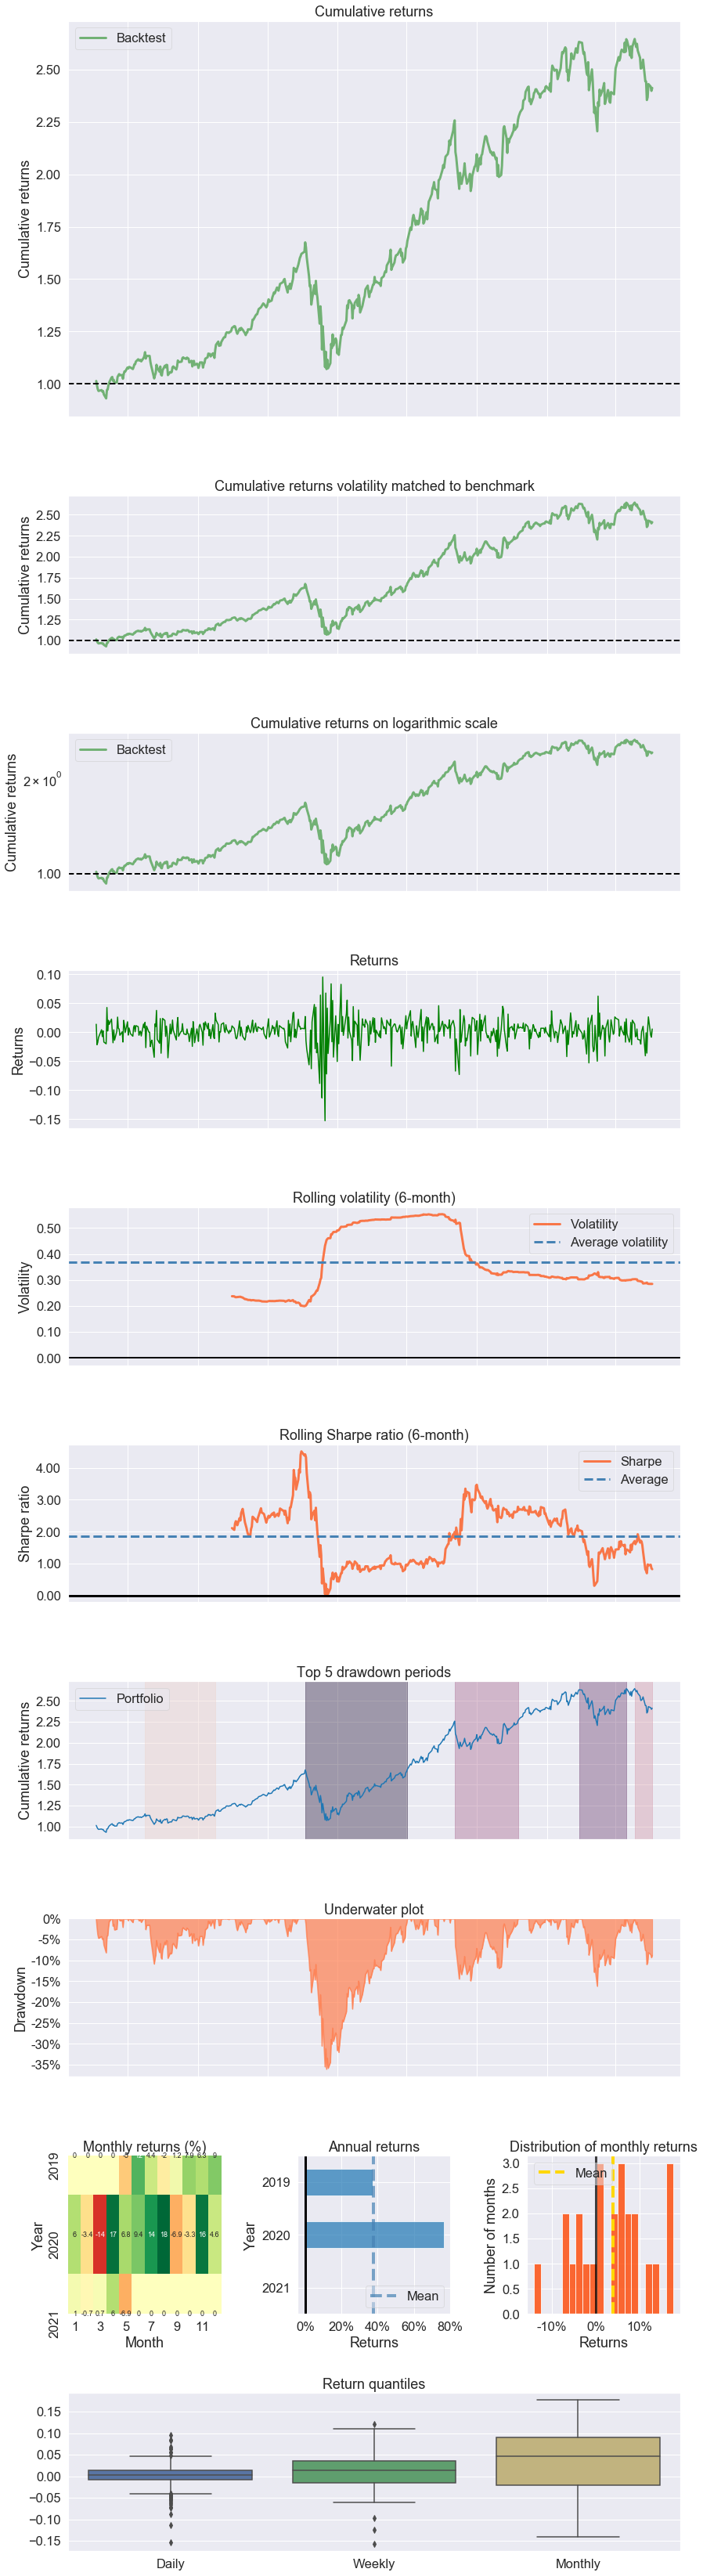

In [44]:
import pyfolio as pf
print("CPD+PCA- top 10")
pf.create_returns_tear_sheet(df)

## ICA

In [45]:
num_assets = len(ica.components_[0])//2
dominant_assets_ica = ica_tech.sort_values().index[-num_assets:]
dominant_assets_ica = " ".join(dominant_assets_ica)
dominant_assets_ica

'VZ T V GOOGL IBM NFLX HPQ AMD AMZN QCOM'

In [46]:
test = yf.download(dominant_assets_ica, start="2019-05-19", end="2021-05-20")
returns_test = test["Adj Close"].apply(np.log).diff(1)
returns_test = returns_test.stack()
returns_test.index = returns_test.index.set_names(['date', 'asset'])
returns_test = returns_test.unstack()
returns_test = returns_test.stack()
returns_test

[*********************100%***********************]  10 of 10 completed


date        asset
2019-05-21  AMD      0.024802
            AMZN    -0.000780
            GOOGL    0.008508
            HPQ      0.025001
            IBM      0.009795
                       ...   
2021-05-19  NFLX     0.002916
            QCOM     0.013484
            T       -0.020168
            V       -0.004354
            VZ      -0.004557
Length: 5040, dtype: float64

In [47]:
mean_returns = []
for i in range(0,len(returns_test),num_assets):
    mean_returns.append(returns_test[i:i+num_assets].mean())
mean_returns

[0.011697087846366961,
 -0.011410954496290149,
 -0.01661771263398757,
 0.0037736802304703778,
 0.0044751976065597445,
 -0.012723328498512387,
 -7.194130430607793e-05,
 -0.021882507784381965,
 -0.008138968524245938,
 0.028650467198167728,
 0.0026916449950716626,
 0.014208263299801205,
 0.012850875716892762,
 0.0058138437655349765,
 0.0013526638929773239,
 -0.003925847851252939,
 -0.00022668563293288814,
 -0.005975227566269359,
 -0.00014069406231675963,
 0.01577943330786069,
 0.004346606539071374,
 0.005478471763318194,
 -0.0015108616470627112,
 0.0024205442006045796,
 -0.012722254470821249,
 0.006840715390332486,
 0.0071629160438570596,
 0.0014346288624663473,
 0.011162334630583937,
 0.006580326488194554,
 0.004904894601307585,
 0.0027955262145038075,
 -0.004143012462955786,
 0.004109221725949253,
 0.005411852880108059,
 -0.0024294863319958004,
 0.004673614086103584,
 0.005304772620960208,
 -0.003149205406387168,
 -0.00538568473262373,
 -0.009500235951955639,
 -0.008503733443177142,
 -0

In [48]:
df = pd.Series(mean_returns,index=sorted(list(set(returns_test.index.get_level_values('date')))))

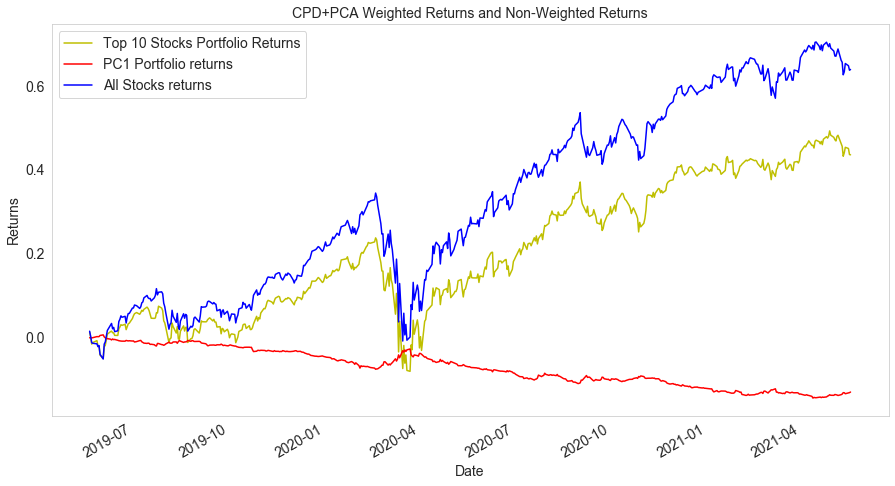

In [49]:
fig,ax = plt.subplots(1,figsize=(15, 8))
df.cumsum().plot(ax=ax, style='y-')
df_w.cumsum().plot(ax=ax, style='r-')
mean_ica.cumsum().plot(ax=ax, style='b-',fontsize=14)
ax.legend(['Top 10 Stocks Portfolio Returns','PC1 Portfolio returns','All Stocks returns'],fontsize=14)
ax.set_title("CPD+PCA Weighted Returns and Non-Weighted Returns",fontsize=14)
ax.set_ylabel('Returns', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.grid()

CPD+ICA- top 10


Start date,2019-05-21
End date,2021-05-19
Total months,24
,Backtest
Annual return,19.989%
Cumulative returns,43.973%
Annual volatility,26.573%
Sharpe ratio,0.82
Calmar ratio,0.68
Stability,0.81
Max drawdown,-29.295%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.30,2020-02-19,2020-03-23,2020-08-04,120
1,11.62,2020-09-02,2020-10-28,2020-12-01,65
2,8.79,2019-07-26,2019-10-08,2019-11-07,75
3,6.12,2019-05-21,2019-06-03,2019-06-10,15
4,5.94,2021-04-29,2021-05-12,NaT,NaN


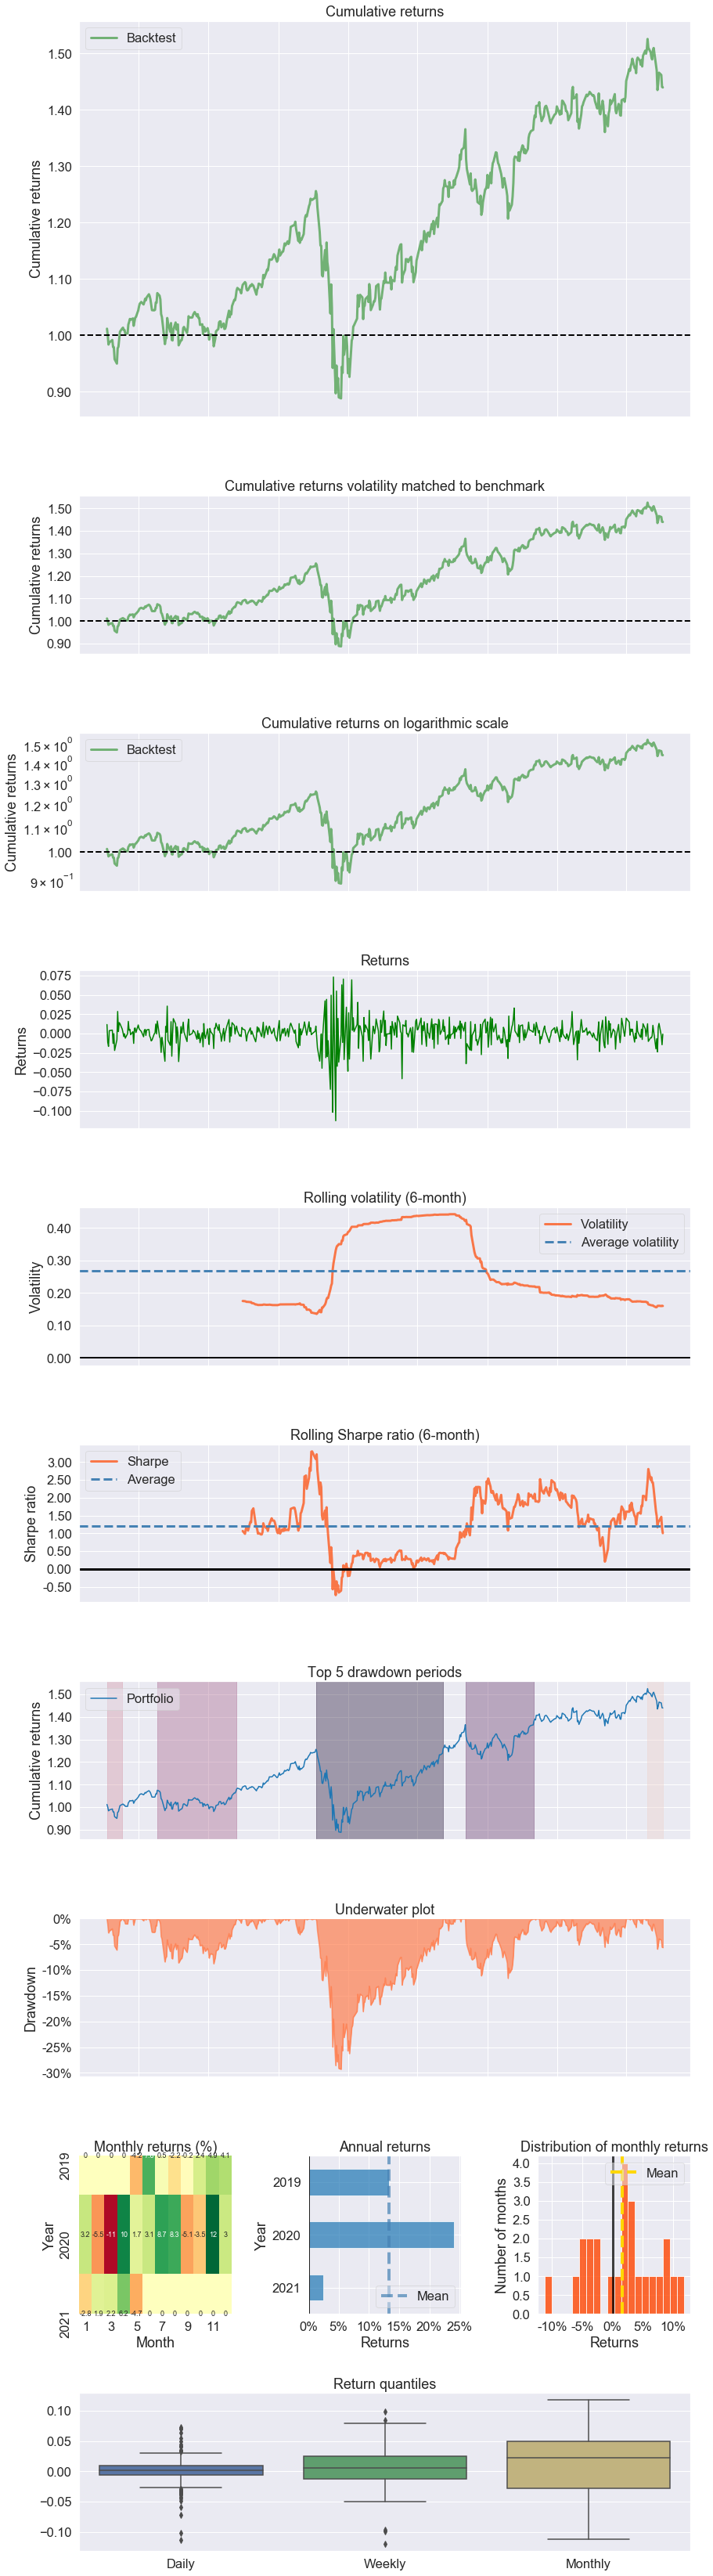

In [50]:
import pyfolio as pf
print("CPD+ICA- top 10")
pf.create_returns_tear_sheet(df)